# 1. Install Packages

In [ ]:
!pip install salesforce-merlion
!git clone https://github.com/salesforce/Merlion.git
!pip install Merlion/ts_datasets/

fatal: destination path 'Merlion' already exists and is not an empty directory.
Processing ./Merlion/ts_datasets
  Preparing metadata (setup.py) ... done
  Created wheel for ts-datasets: filename=ts_datasets-0.1.0-py3-none-any.whl size=28760 sha256=45bbf77c4e1cddf572d292aa578bf914e67ef11f07f790befe1cc867b2150e75
  Stored in directory: /tmp/pip-ephem-wheel-cache-9eof50co/wheels/2c/b6/40/b02460ead944003f35edca35c96d734ab4e66b5ea0b1f08e68
Successfully built ts-datasets
  Attempting uninstall: ts-datasets
    Found existing installation: ts-datasets 0.1.0
    Uninstalling ts-datasets-0.1.0:
      Successfully uninstalled ts-datasets-0.1.0


# 2. Fix bugs in Merlion

We discovered a bug in the NAB.py dataloader.


1.   Open /usr/local/lib/python3.10/dist-packages/ts_datasets/anomaly/nab.py
2.   Replace line 87 with

   ```
   all_dt = np.unique(np.diff(df["timestamp"]))
   ```
3.   Save nab.py and restart runtime, but do not re-install packages.





# 3. Imports

In [ ]:
import numpy as np
import pandas as pd
import keras

from keras import layers


from matplotlib import pyplot as plt

from merlion.models.factory import ModelFactory
from merlion.models.defaults import DefaultDetectorConfig, DefaultDetector
from merlion.utils import TimeSeries
from merlion.plot import plot_anoms
from merlion.post_process.threshold import AggregateAlarms
from merlion.evaluate.anomaly import TSADMetric

from ts_datasets.anomaly import NAB
from ts_datasets.anomaly import MSL
from ts_datasets.anomaly import SMAP

# 4. Univariate Time Series

NAB - Real Known Cause - ec2_request_latency_system_failure.csv

In [ ]:
time_series1, metadata1 = NAB(subset="realKnownCause")[2]
train_data1 = TimeSeries.from_pd(time_series1[metadata1.trainval])
test_data1 = TimeSeries.from_pd(time_series1[~metadata1.trainval])
test_labels1 = TimeSeries.from_pd(metadata1.anomaly[~metadata1.trainval])

In [ ]:
from merlion.models.factory import ModelFactory
from merlion.post_process.threshold import AggregateAlarms

uni_model_zms = ModelFactory.create("ZMS",
                             threshold=AggregateAlarms(alm_threshold=2))

uni_model_if = ModelFactory.create("IsolationForest",
                             threshold=AggregateAlarms(alm_threshold=2))

uni_model_rcf = ModelFactory.create("RandomCutForest",
                             threshold=AggregateAlarms(alm_threshold=2))

uni_model_ae = ModelFactory.create("AutoEncoder",
                             threshold=AggregateAlarms(alm_threshold=2))

uni_model_vae = ModelFactory.create("VAE",
                             threshold=AggregateAlarms(alm_threshold=2))

uni_model_dpad = ModelFactory.create("DeepPointAnomalyDetector",
                             threshold=AggregateAlarms(alm_threshold=2))

for uni_model in [uni_model_zms, uni_model_if, uni_model_rcf, uni_model_ae,
              uni_model_vae, uni_model_dpad]:
    print(f"Training {type(uni_model).__name__}...")
    train_scores1 = uni_model.train(train_data1)

Training ZMS...
Training IsolationForest...
Training RandomCutForest...
Training AutoEncoder...
 |========================================| 100.0% Complete, Loss 0.0026
Training VAE...
 |========================================| 100.0% Complete, Loss 0.0020
Training DeepPointAnomalyDetector...


In [ ]:
test_pred_zms = uni_model_zms.get_anomaly_label(time_series=test_data1)
test_pred_if = uni_model_if.get_anomaly_label(time_series=test_data1)
test_pred_rcf = uni_model_rcf.get_anomaly_label(time_series=test_data1)
test_pred_ae = uni_model_ae.get_anomaly_label(time_series=test_data1)
test_pred_vae = uni_model_vae.get_anomaly_label(time_series=test_data1)
test_pred_dpad = uni_model_dpad.get_anomaly_label(time_series=test_data1)

Visualize anomalies

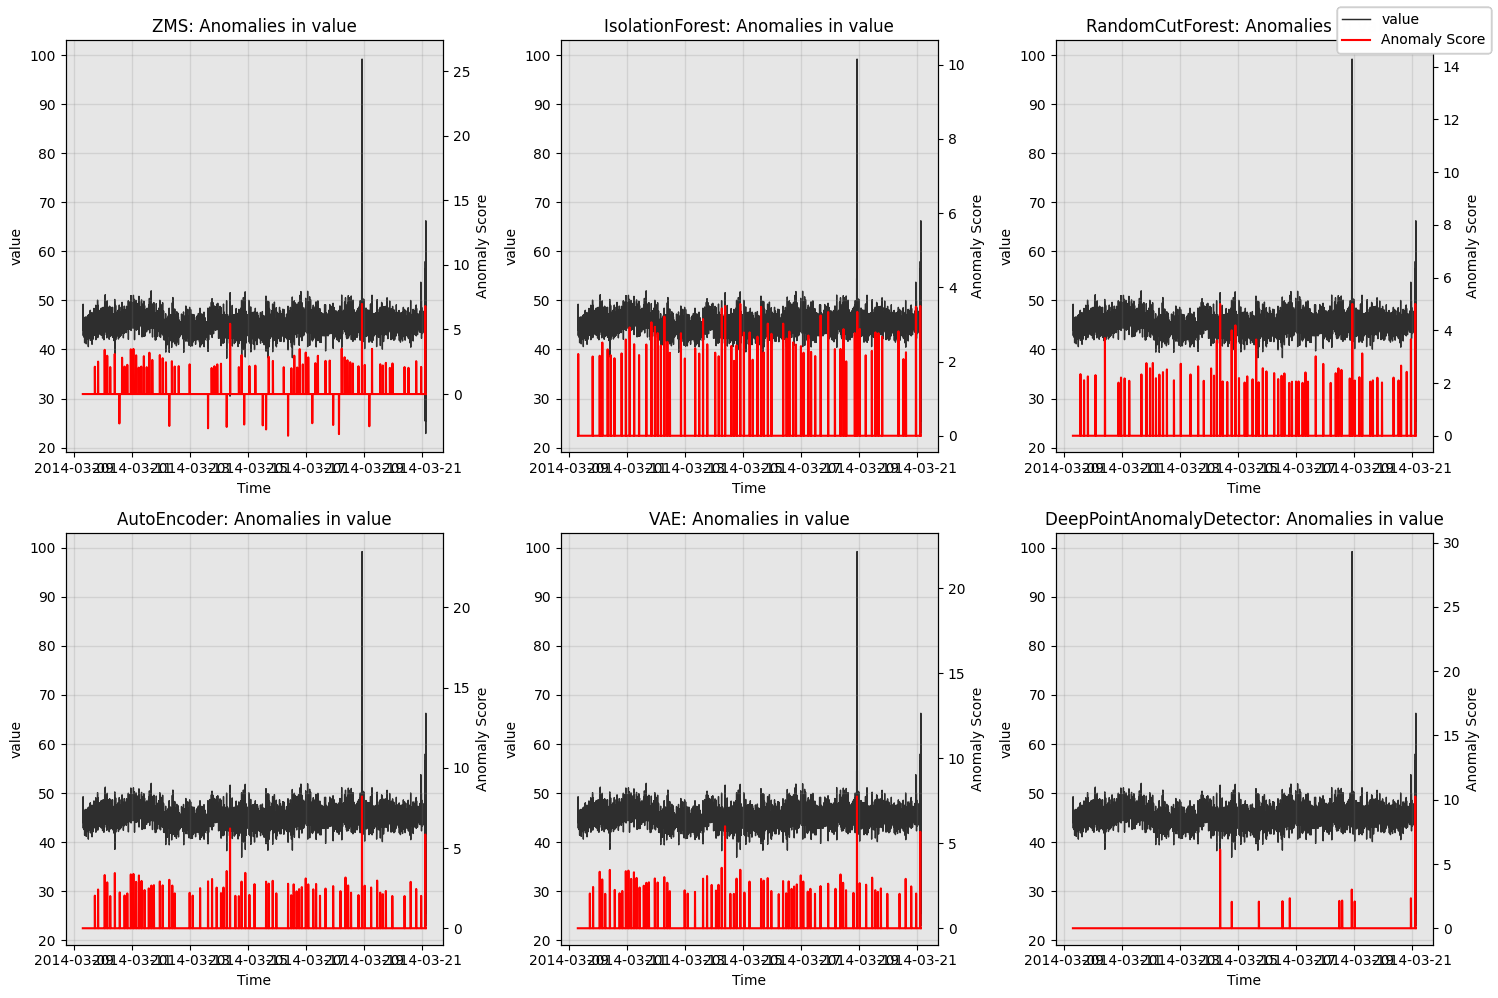

In [ ]:
# Test predictions and plots for each model
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Model: uni_model_zms
uni_model_zms.plot_anomaly(time_series=test_data1, ax=axs[0, 0])
plot_anoms(axs[0, 0], anomaly_labels=test_labels1)

# Model: uni_model_if
uni_model_if.plot_anomaly(time_series=test_data1, ax=axs[0, 1])
plot_anoms(axs[0, 1], anomaly_labels=test_labels1)

# Model: uni_model_rcf
uni_model_rcf.plot_anomaly(time_series=test_data1, ax=axs[0, 2])
plot_anoms(axs[0, 2], anomaly_labels=test_labels1)

# Model: uni_model_ae
uni_model_ae.plot_anomaly(time_series=test_data1, ax=axs[1, 0])
plot_anoms(axs[1, 0], anomaly_labels=test_labels1)

# Model: uni_model_vae
uni_model_vae.plot_anomaly(time_series=test_data1, ax=axs[1, 1])
plot_anoms(axs[1, 1], anomaly_labels=test_labels1)

# Model: uni_model_dpad
uni_model_dpad.plot_anomaly(time_series=test_data1, ax=axs[1, 2])
plot_anoms(axs[1, 2], anomaly_labels=test_labels1)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


Evaluate models

In [ ]:
for model in [uni_model_zms, uni_model_if, uni_model_rcf, uni_model_ae,
              uni_model_vae, uni_model_dpad]:
    labels = model.get_anomaly_label(test_data1)
    precision = TSADMetric.PointAdjustedPrecision.value(ground_truth=test_labels1, predict=labels)
    recall = TSADMetric.PointAdjustedRecall.value(ground_truth=test_labels1, predict=labels)
    f1 = TSADMetric.PointAdjustedF1.value(ground_truth=test_labels1, predict=labels)
    mttd = TSADMetric.MeanTimeToDetect.value(ground_truth=test_labels1, predict=labels)
    print(f"{type(model).__name__}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1:        {f1:.4f}")
    print(f"MTTD:      {mttd}")
    print()

ZMS
Precision: 0.8278
Recall:    1.0000
F1:        0.9058
MTTD:      0 days 02:33:20

IsolationForest
Precision: 0.8480
Recall:    1.0000
F1:        0.9178
MTTD:      0 days 02:01:40

RandomCutForest
Precision: 0.8501
Recall:    1.0000
F1:        0.9190
MTTD:      0 days 02:06:40

AutoEncoder
Precision: 0.8418
Recall:    1.0000
F1:        0.9141
MTTD:      0 days 01:40:00

VAE
Precision: 0.8398
Recall:    1.0000
F1:        0.9129
MTTD:      0 days 01:40:00

DeepPointAnomalyDetector
Precision: 0.9830
Recall:    1.0000
F1:        0.9914
MTTD:      0 days 04:21:40



NAB - Real Known Cause - machine_temperature_system_failure.csv

In [ ]:
time_series2, metadata2 = NAB(subset="realKnownCause")[3]
train_data2 = TimeSeries.from_pd(time_series2[metadata2.trainval])
test_data2 = TimeSeries.from_pd(time_series2[~metadata2.trainval])
test_labels2 = TimeSeries.from_pd(metadata2.anomaly[~metadata2.trainval])

In [ ]:
from merlion.models.factory import ModelFactory
from merlion.post_process.threshold import AggregateAlarms

uni_model_zms2 = ModelFactory.create("ZMS",
                             threshold=AggregateAlarms(alm_threshold=2))

uni_model_if2 = ModelFactory.create("IsolationForest",
                             threshold=AggregateAlarms(alm_threshold=2))

uni_model_rcf2 = ModelFactory.create("RandomCutForest",
                             threshold=AggregateAlarms(alm_threshold=2))

uni_model_ae2 = ModelFactory.create("AutoEncoder",
                             threshold=AggregateAlarms(alm_threshold=2))

uni_model_vae2 = ModelFactory.create("VAE",
                             threshold=AggregateAlarms(alm_threshold=2))

uni_model_dpad2 = ModelFactory.create("DeepPointAnomalyDetector",
                             threshold=AggregateAlarms(alm_threshold=2))

for uni_model in [uni_model_zms2, uni_model_if2, uni_model_rcf2, uni_model_ae2,
              uni_model_vae2, uni_model_dpad2]:
    print(f"Training {type(uni_model).__name__}...")
    train_scores2 = uni_model.train(train_data2)

Training ZMS...
Training IsolationForest...
Training RandomCutForest...
Training AutoEncoder...
 |========================================| 100.0% Complete, Loss 0.0000
Training VAE...
 |========================================| 100.0% Complete, Loss 0.0014
Training DeepPointAnomalyDetector...


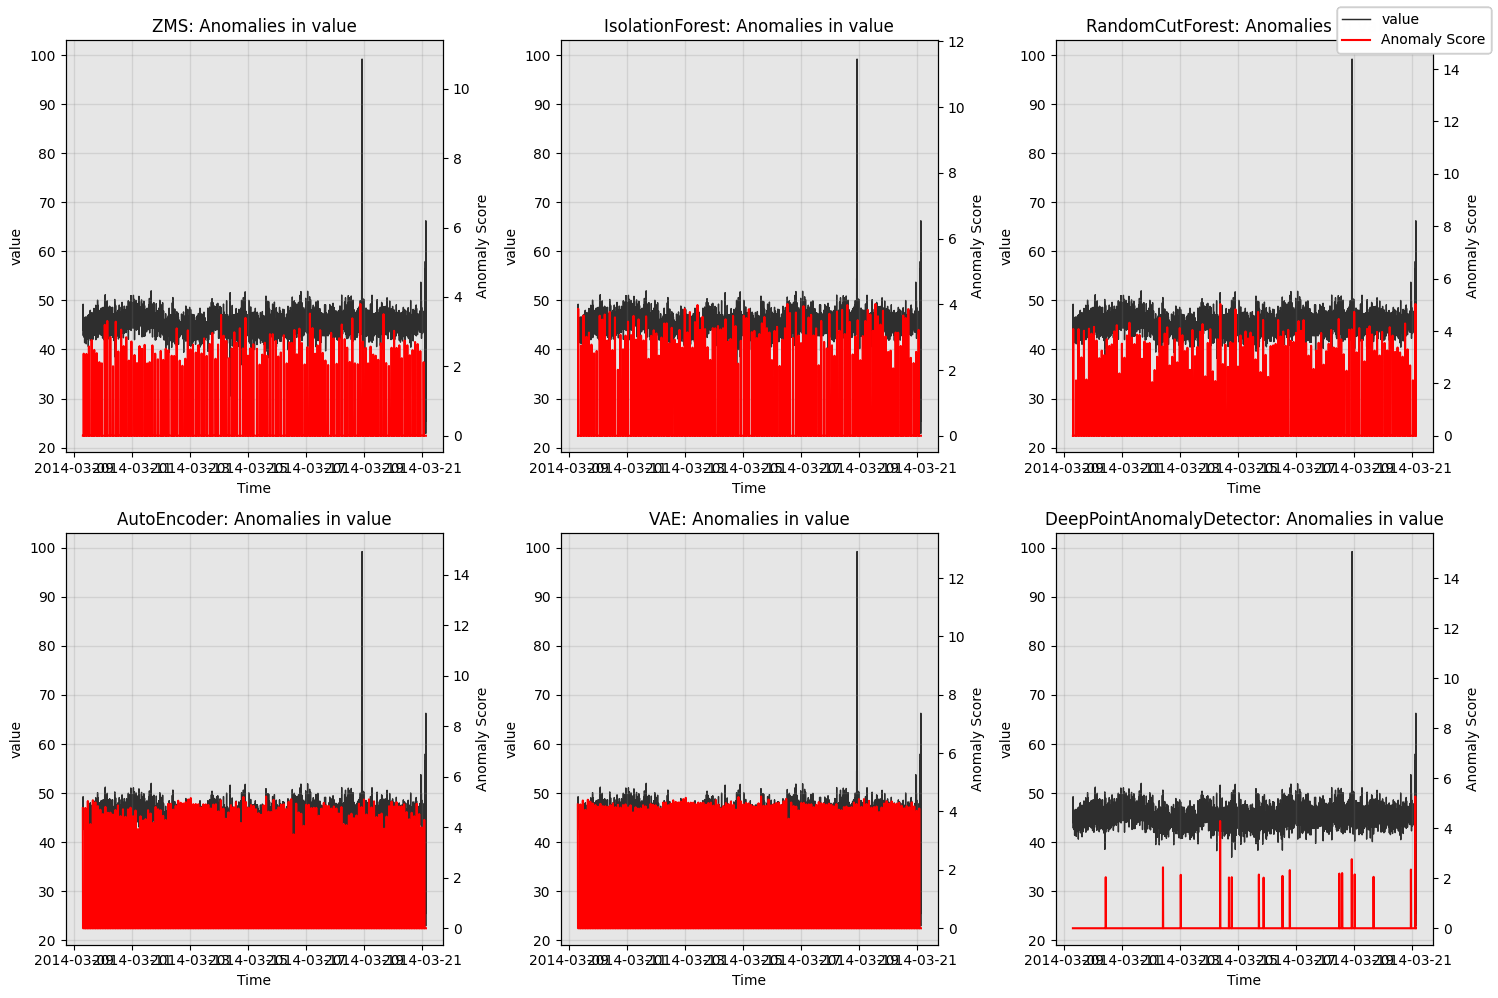

In [ ]:
# Test predictions and plots for each model
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Model: uni_model_zms
uni_model_zms2.plot_anomaly(time_series=test_data1, ax=axs[0, 0])
plot_anoms(axs[0, 0], anomaly_labels=test_labels2)

# Model: uni_model_if
uni_model_if2.plot_anomaly(time_series=test_data1, ax=axs[0, 1])
plot_anoms(axs[0, 1], anomaly_labels=test_labels2)

# Model: uni_model_rcf
uni_model_rcf2.plot_anomaly(time_series=test_data1, ax=axs[0, 2])
plot_anoms(axs[0, 2], anomaly_labels=test_labels2)

# Model: uni_model_ae
uni_model_ae2.plot_anomaly(time_series=test_data1, ax=axs[1, 0])
plot_anoms(axs[1, 0], anomaly_labels=test_labels2)

# Model: uni_model_vae
uni_model_vae2.plot_anomaly(time_series=test_data1, ax=axs[1, 1])
plot_anoms(axs[1, 1], anomaly_labels=test_labels2)

# Model: uni_model_dpad
uni_model_dpad2.plot_anomaly(time_series=test_data1, ax=axs[1, 2])
plot_anoms(axs[1, 2], anomaly_labels=test_labels2)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
for model in [uni_model_zms2, uni_model_if2, uni_model_rcf2, uni_model_ae2,
              uni_model_vae2, uni_model_dpad2]:
    labels = model.get_anomaly_label(test_data2)
    precision2 = TSADMetric.PointAdjustedPrecision.value(ground_truth=test_labels2, predict=labels)
    recall2 = TSADMetric.PointAdjustedRecall.value(ground_truth=test_labels2, predict=labels)
    f12 = TSADMetric.PointAdjustedF1.value(ground_truth=test_labels2, predict=labels)
    mttd2 = TSADMetric.MeanTimeToDetect.value(ground_truth=test_labels2, predict=labels)
    print(f"{type(model).__name__}")
    print(f"Precision: {precision2:.4f}")
    print(f"Recall:    {recall2:.4f}")
    print(f"F1:        {f12:.4f}")
    print(f"MTTD:      {mttd2}")
    print()

ZMS
Precision: 0.9466
Recall:    1.0000
F1:        0.9726
MTTD:      0 days 03:28:20

IsolationForest
Precision: 0.8924
Recall:    1.0000
F1:        0.9432
MTTD:      0 days 02:15:00

RandomCutForest
Precision: 0.9240
Recall:    1.0000
F1:        0.9605
MTTD:      0 days 02:20:00

AutoEncoder
Precision: 0.9924
Recall:    1.0000
F1:        0.9962
MTTD:      0 days 08:20:00

VAE
Precision: 0.9942
Recall:    1.0000
F1:        0.9971
MTTD:      0 days 12:18:20

DeepPointAnomalyDetector
Precision: 0.9393
Recall:    1.0000
F1:        0.9687
MTTD:      0 days 02:58:20



# 5. Multivariate Time Series

In [ ]:
def plot_intermediate(model,test_labels, test_data):
  res = model.get_anomaly_label(test_data)
  ts=[]
  time_stamp=[]
  test_bool=[]
  pred_bool=[]
  for var in res.univariates:
    for i in var:
      ts.append(i)
  for i in range(len(ts)):
    time_stamp.append(ts[i][0])
    pred_bool.append(ts[i][1])
  ts1 = [] # to extract test label data
  for var in test_labels.univariates:
    for i in var[1:]:
      ts1.append(i)
  for i in range(len(ts1)):
    test_bool.append(ts[i][1])
  #print(len(pred_bool) , len(test_bool))
  return time_stamp, test_bool, pred_bool

Mars Science Laboratory (MSL) rover data

In [ ]:
time_series3, metadata3 = MSL()[0]
train_data3 = TimeSeries.from_pd(time_series3[metadata3.trainval])
test_data3 = TimeSeries.from_pd(time_series3[~metadata3.trainval])
test_labels3 = TimeSeries.from_pd(metadata3.anomaly[~metadata3.trainval])

print(f"Time series is {train_data3.dim}-dimensional")

Time series is 55-dimensional


In [ ]:
multi_model_if = ModelFactory.create("IsolationForest",
                             threshold=AggregateAlarms(alm_threshold=2))

multi_model_rcf = ModelFactory.create("RandomCutForest",
                             threshold=AggregateAlarms(alm_threshold=2))

multi_model_ae = ModelFactory.create("AutoEncoder",
                             threshold=AggregateAlarms(alm_threshold=2))

multi_model_vae = ModelFactory.create("VAE",
                             threshold=AggregateAlarms(alm_threshold=2))

multi_model_dpad = ModelFactory.create("DeepPointAnomalyDetector",
                             threshold=AggregateAlarms(alm_threshold=2))

for multi_model in [multi_model_if, multi_model_rcf, multi_model_ae,
              multi_model_vae, multi_model_dpad]:
    print(f"Training {type(multi_model).__name__}...")
    train_scores3 = multi_model.train(train_data3)

Training IsolationForest...
Training RandomCutForest...
Training AutoEncoder...
 |========================================| 100.0% Complete, Loss 0.0006
Training VAE...
 |========================================| 100.0% Complete, Loss 0.0006
Training DeepPointAnomalyDetector...


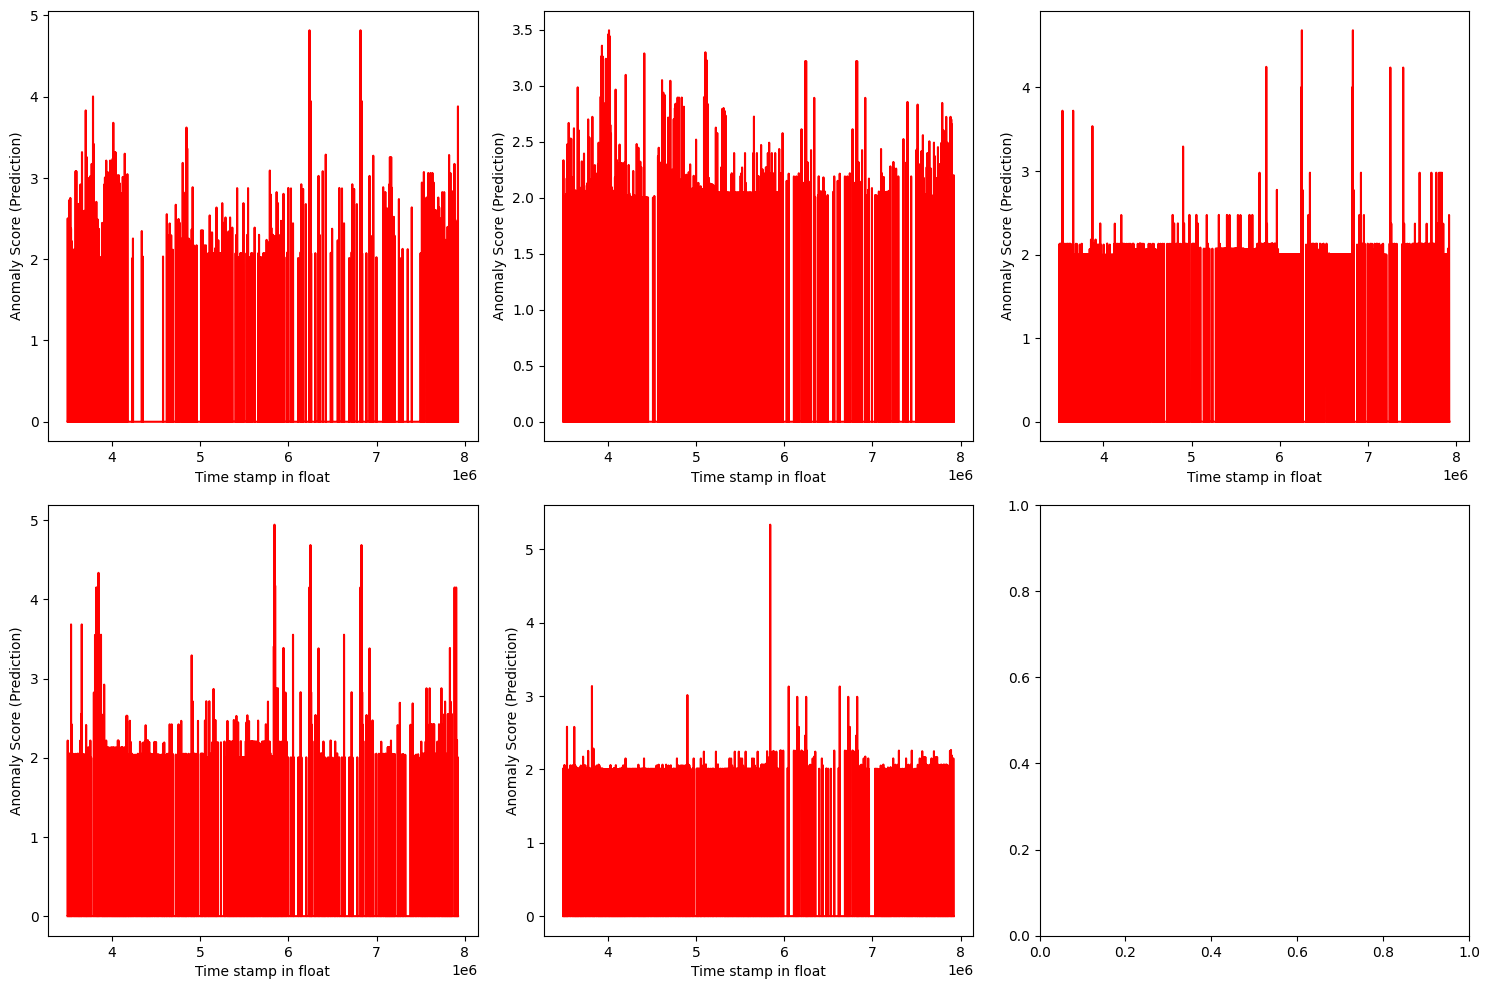

In [ ]:
# Test predictions and plots for each model
fig, axs = plt.subplots(2, 3, figsize=(15, 10))


# Model: uni_model_if
time_stamp2,test_label2,pred_bool2 = plot_intermediate(multi_model_if, test_labels3, test_data3)
axs[0,0].plot(time_stamp2, pred_bool2, linestyle='-', color='r')
axs[0,0].set_xlabel('Time stamp in float')
axs[0,0].set_ylabel('Anomaly Score (Prediction)')

# Model: uni_model_rcf
time_stamp2,test_label2,pred_bool2 = plot_intermediate(multi_model_rcf, test_labels3,test_data3)
axs[0,1].plot(time_stamp2, pred_bool2, linestyle='-', color='r')
axs[0,1].set_xlabel('Time stamp in float')
axs[0,1].set_ylabel('Anomaly Score (Prediction)')

# Model: uni_model_ae
time_stamp2,test_label2,pred_bool2 = plot_intermediate(multi_model_ae, test_labels3,test_data3)
axs[0,2].plot(time_stamp2, pred_bool2, linestyle='-', color='r')
axs[0,2].set_xlabel('Time stamp in float')
axs[0,2].set_ylabel('Anomaly Score (Prediction)')

# Model: uni_model_vae
time_stamp2,test_label2,pred_bool2 = plot_intermediate(multi_model_vae, test_labels3,test_data3)
axs[1,0].plot(time_stamp2, pred_bool2, linestyle='-', color='r')
axs[1,0].set_xlabel('Time stamp in float')
axs[1,0].set_ylabel('Anomaly Score (Prediction)')

# Model: uni_model_dpad
time_stamp2,test_label2,pred_bool2 = plot_intermediate(multi_model_dpad, test_labels3,test_data3)
axs[1,1].plot(time_stamp2, pred_bool2, linestyle='-', color='r')
axs[1,1].set_xlabel('Time stamp in float')
axs[1,1].set_ylabel('Anomaly Score (Prediction)')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
for model in [multi_model_if, multi_model_rcf, multi_model_ae,
              multi_model_vae, multi_model_dpad]:
    labels = model.get_anomaly_label(test_data3)
    precision3 = TSADMetric.PointAdjustedPrecision.value(ground_truth=test_labels3, predict=labels)
    recall3 = TSADMetric.PointAdjustedRecall.value(ground_truth=test_labels3, predict=labels)
    f13 = TSADMetric.PointAdjustedF1.value(ground_truth=test_labels3, predict=labels)
    mttd3 = TSADMetric.MeanTimeToDetect.value(ground_truth=test_labels3, predict=labels)
    print(f"{type(model).__name__}")
    print(f"Precision: {precision3:.4f}")
    print(f"Recall:    {recall3:.4f}")
    print(f"F1:        {f13:.4f}")
    print(f"MTTD:      {mttd3}")
    print()

IsolationForest
Precision: 0.9638
Recall:    0.8192
F1:        0.8856
MTTD:      0 days 01:40:57

RandomCutForest
Precision: 0.9549
Recall:    0.9057
F1:        0.9297
MTTD:      0 days 00:59:16

AutoEncoder
Precision: 0.9495
Recall:    0.8429
F1:        0.8930
MTTD:      0 days 01:16:33

VAE
Precision: 0.9555
Recall:    0.8688
F1:        0.9101
MTTD:      0 days 00:58:18

DeepPointAnomalyDetector
Precision: 0.9543
Recall:    0.8305
F1:        0.8881
MTTD:      0 days 00:59:12



Soil Moisture Active Passive (SMAP) satellite data

In [ ]:
time_series4, metadata4 = SMAP()[0]
train_data4 = TimeSeries.from_pd(time_series4[metadata4.trainval])
test_data4 = TimeSeries.from_pd(time_series4[~metadata4.trainval])
test_labels4 = TimeSeries.from_pd(metadata4.anomaly[~metadata4.trainval])

print(f"Time series is {train_data4.dim}-dimensional")

Time series is 25-dimensional


In [ ]:
multi_model_if2 = ModelFactory.create("IsolationForest",
                             threshold=AggregateAlarms(alm_threshold=2))

multi_model_rcf2 = ModelFactory.create("RandomCutForest",
                             threshold=AggregateAlarms(alm_threshold=2))

multi_model_ae2 = ModelFactory.create("AutoEncoder",
                             threshold=AggregateAlarms(alm_threshold=2))

multi_model_vae2 = ModelFactory.create("VAE",
                             threshold=AggregateAlarms(alm_threshold=2))

multi_model_dpad2 = ModelFactory.create("DeepPointAnomalyDetector",
                             threshold=AggregateAlarms(alm_threshold=2))

for multi_model in [multi_model_if2, multi_model_rcf2, multi_model_ae2,
              multi_model_vae2, multi_model_dpad2]:
    print(f"Training {type(multi_model).__name__}...")
    train_scores4 = multi_model.train(train_data4)

Training IsolationForest...
Training RandomCutForest...
Training AutoEncoder...
 |========================================| 100.0% Complete, Loss 0.0002
Training VAE...
 |========================================| 100.0% Complete, Loss 0.0009
Training DeepPointAnomalyDetector...


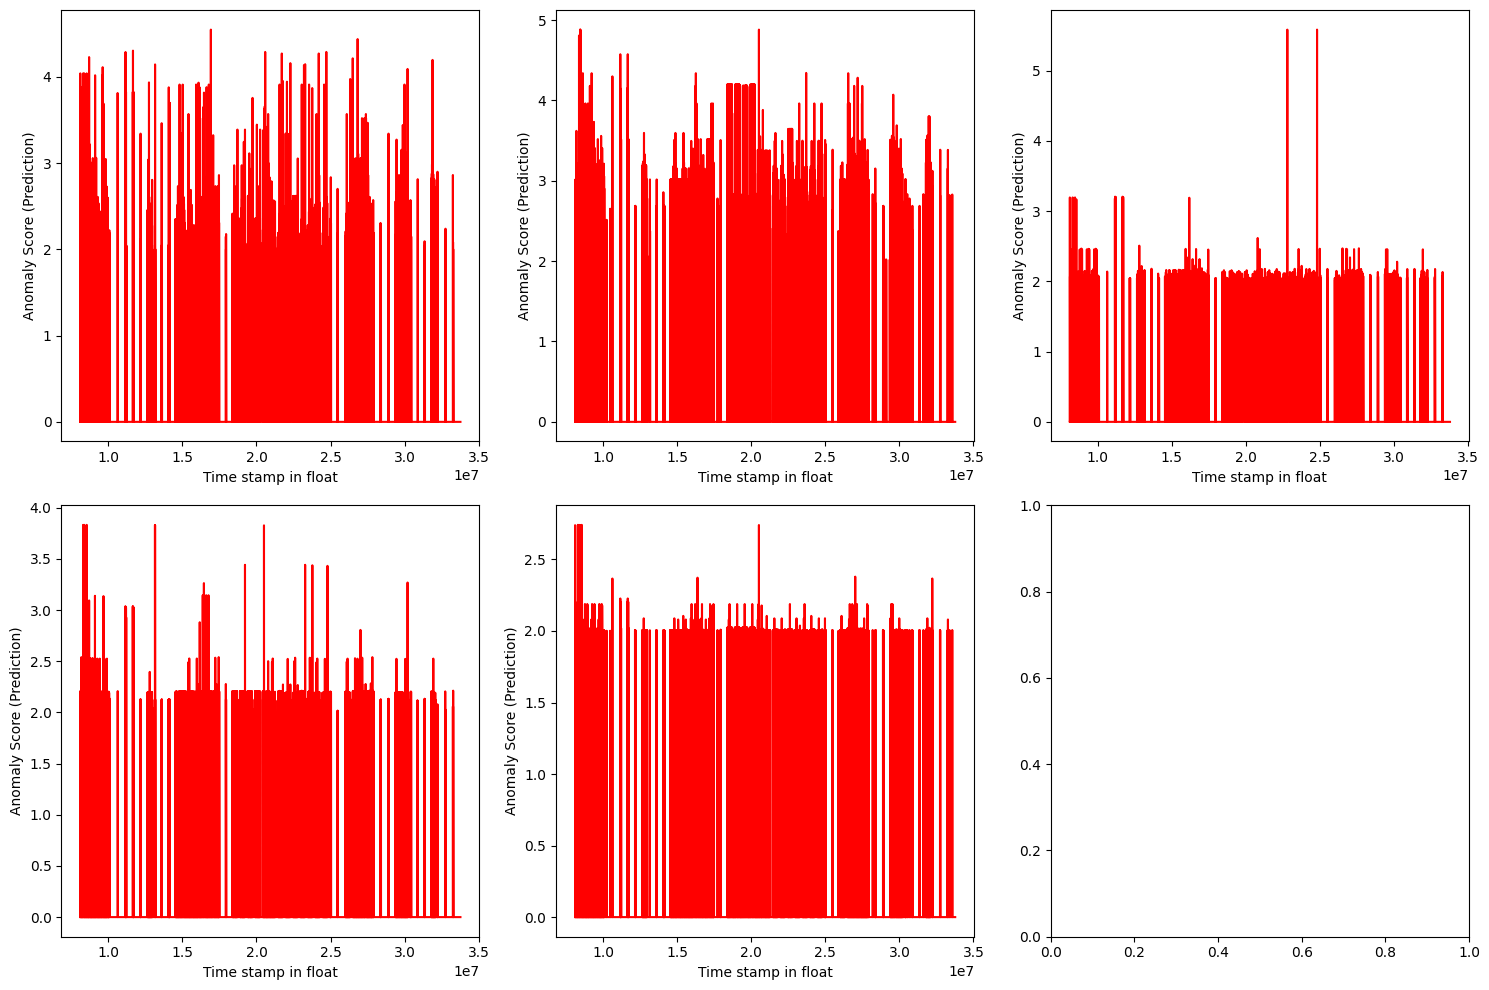

In [ ]:

# Test predictions and plots for each model
fig, axs = plt.subplots(2, 3, figsize=(15, 10))


# Model: uni_model_if
time_stamp4,test_label4,pred_bool4 = plot_intermediate(multi_model_if2, test_labels4, test_data4)
axs[0,0].plot(time_stamp4, pred_bool4, linestyle='-', color='r')
axs[0,0].set_xlabel('Time stamp in float')
axs[0,0].set_ylabel('Anomaly Score (Prediction)')

# Model: uni_model_rcf
time_stamp4,test_label4,pred_bool4 = plot_intermediate(multi_model_rcf2, test_labels4,test_data4)
axs[0,1].plot(time_stamp4, pred_bool4, linestyle='-', color='r')
axs[0,1].set_xlabel('Time stamp in float')
axs[0,1].set_ylabel('Anomaly Score (Prediction)')

# Model: uni_model_ae
time_stamp2,test_label4,pred_bool4 = plot_intermediate(multi_model_ae2, test_labels4,test_data4)
axs[0,2].plot(time_stamp2, pred_bool4, linestyle='-', color='r')
axs[0,2].set_xlabel('Time stamp in float')
axs[0,2].set_ylabel('Anomaly Score (Prediction)')

# Model: uni_model_vae
time_stamp4,test_label4,pred_bool4 = plot_intermediate(multi_model_vae2, test_labels4,test_data4)
axs[1,0].plot(time_stamp4, pred_bool4, linestyle='-', color='r')
axs[1,0].set_xlabel('Time stamp in float')
axs[1,0].set_ylabel('Anomaly Score (Prediction)')

# Model: uni_model_dpad
time_stamp4,test_label4,pred_bool4 = plot_intermediate(multi_model_dpad2, test_labels4,test_data4)
axs[1,1].plot(time_stamp4, pred_bool4, linestyle='-', color='r')
axs[1,1].set_xlabel('Time stamp in float')
axs[1,1].set_ylabel('Anomaly Score (Prediction)')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
for model in [multi_model_if2, multi_model_rcf2, multi_model_ae2,
              multi_model_vae2, multi_model_dpad2]:
    labels = model.get_anomaly_label(test_data4)
    precision4 = TSADMetric.PointAdjustedPrecision.value(ground_truth=test_labels4, predict=labels)
    recall4 = TSADMetric.PointAdjustedRecall.value(ground_truth=test_labels4, predict=labels)
    f14 = TSADMetric.PointAdjustedF1.value(ground_truth=test_labels4, predict=labels)
    mttd4 = TSADMetric.MeanTimeToDetect.value(ground_truth=test_labels4, predict=labels)
    print(f"{type(model).__name__}")
    print(f"Precision: {precision4:.4f}")
    print(f"Recall:    {recall4:.4f}")
    print(f"F1:        {f14:.4f}")
    print(f"MTTD:      {mttd4}")
    print()

IsolationForest
Precision: 0.9579
Recall:    0.5201
F1:        0.6742
MTTD:      0 days 00:35:42

RandomCutForest
Precision: 0.9616
Recall:    0.6600
F1:        0.7828
MTTD:      0 days 01:32:35

AutoEncoder
Precision: 0.9579
Recall:    0.5433
F1:        0.6934
MTTD:      0 days 00:37:05

VAE
Precision: 0.9562
Recall:    0.5137
F1:        0.6683
MTTD:      0 days 00:47:53

DeepPointAnomalyDetector
Precision: 0.9617
Recall:    0.6305
F1:        0.7617
MTTD:      0 days 01:37:01

